# Find Movie Similarity from Plot Summaries
Many movies are created based on various interesting themes. Some people like superhero movies, while others like horror movies. However, just knowing the name or genre of a movie may not be enough to determine if we like it or not. Therefore, we need to read the plot of these movies first to find out if we like them.

Moreover, with so many movies available nowadays, it can take a long time to read the plot of each movie to find the ones we like. In this notebook, we will quantify the similarity of movies based on their plot summaries available on IMDb and Wikipedia, and then cluster them into groups. This will allow us to find movies with similar plots to the ones we like. We'll create a dendrogram to represent how closely the movies are related to each other


Outline
1. Importing the dataset 
    - these dataset get from wikipedia and imdb that contain plot on each movies.
2. Pre Proccessing Data
    1. Combine Wikipedia and IMDb plot summaries.
        - Combining plot summaries from both Wikipedia and IMDb will provide a larger dataset for analysis and more accurate results.
    2. Tokenization
        - Tokenization breaks down the plot summaries into individual words for analysis.
    3. Stemming
        - Stemming reduces words to their root form for more effective analysis.
    4. Combining Tokenize & Stem
        - Combining tokenization and stemming will create a more efficient dataset for analysis.
    5. Create TfidfVectorizer and Fit transform TfidfVectorizer
        - TfidfVectorizer will convert the plot summaries into numerical vectors for analysis.
        - Fit transform TfidfVectorizer to convert the plot summaries into numerical vectors for clustering.

3. Modeling
    1. Import KMeans and create clusters
        - Importing KMeans and creating clusters will group the movies with similar plots together.
    2. Calculate similarity distance
        - Calculating similarity distance will help identify which movies are more similar to each other.

4. Validation
    1. Evaluating the performance of the clustering algorithm
    
5. Data Visuialization
    1. Import Matplotlib, Linkage, and Dendrograms
        - Importing Matplotlib, Linkage, and Dendrograms will create a visual representation of the relationship between the movies.
    2. Create merging and plot dendrogram
        - Creating merging and plotting dendrograms will allow for a better understanding of the clusters formed and which movies are more closely related to each other.

## 1. Importing the dataset 

In [413]:
# Import modules
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

# Set seed for reproducibility
np.random.seed(5)

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv('datasets/movies.csv')

print("Number of movies loaded: %s " % (len(movies_df)))

# Display the data
movies_df

Number of movies loaded: 100 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abi7o\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc..."
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin..."


## 2. Pre Proccessing Data

### 1. Combine Wikipedia and IMDb plot summaries.

In [414]:
# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" + \
                 movies_df['imdb_plot'].astype(str)

# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


### 2. Tokenization

In [415]:
# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]
print(sent_tokenized)
# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]
print(words_tokenized)
# Remove tokens that do not contain any letters from words_tokenized
import re

filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
print(filtered)

["\n                        Today (May 19, 2016) is his only daughter's wedding.", 'Vito Corleone is the Godfather.']
['Today', '(', 'May', '19', ',', '2016', ')', 'is', 'his', 'only', 'daughter', "'s", 'wedding', '.']
['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']


### 3. Stemming

In [416]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(t) for t in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


### 4. Combining Tokenize & Stem

In [417]:
# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


### 5. Create TfidfVectorizer and Fit transform TfidfVectorizer

In [418]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

In [419]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix.toarray())

[[0.01529933 0.04667991 0.         ... 0.05830305 0.04014884 0.        ]
 [0.05828674 0.         0.         ... 0.         0.00955983 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01324472 0.14817389 0.         ... 0.         0.01737854 0.        ]
 [0.01413212 0.         0.         ... 0.0269275  0.01854291 0.        ]
 [0.20333483 0.         0.         ... 0.         0.06669946 0.        ]]


## 3. Modeling

### 1. Import KMeans and create clusters

In [420]:
# Import k-means to perform clustering
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts() 

2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64

In [421]:
movies_df

,rank,title,genre,wiki_plot,imdb_plot,plot,cluster
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit...",2
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ...",3
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the...",1
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight...",2
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...,3
...,...,...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...,\n\n\n\nJim Stark is in police custody.\n\n \...,2
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat...",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,2
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc...",\n\n\n\nSocial network mapping all major chara...,2
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin...",Advertising executive Roger O. Thornhill is mi...,0


In [422]:
movies_df['cluster'].value_counts() 

2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64

### 2. Calculate similarity distance

In [423]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

## 4. Validation

### 1. Evaluating the performance of the clustering algorithm

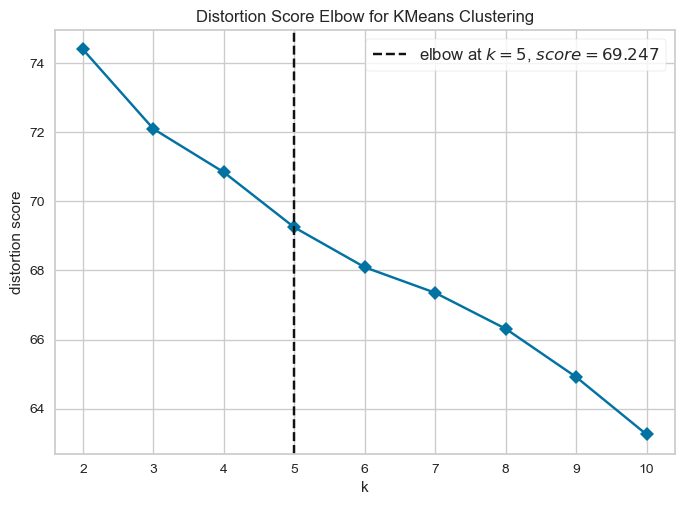

In [424]:
# plot elbow
plot_model(kmeans, plot = 'elbow')

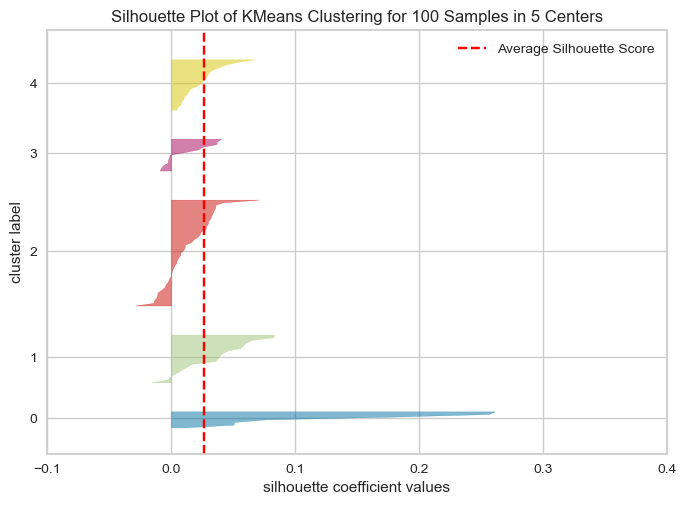

In [425]:
# plot silhouette
plot_model(kmeans, plot = 'silhouette')

In [426]:
plot_model(kmeans, plot = 'distribution')

## 5. Data Visuialization

### 1. Import Matplotlib, Linkage, and Dendrograms

In [427]:
# Import matplotlib.pyplot for plotting graphs
import matplotlib.pyplot as plt

# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

### 2. Create merging and plot dendrogram

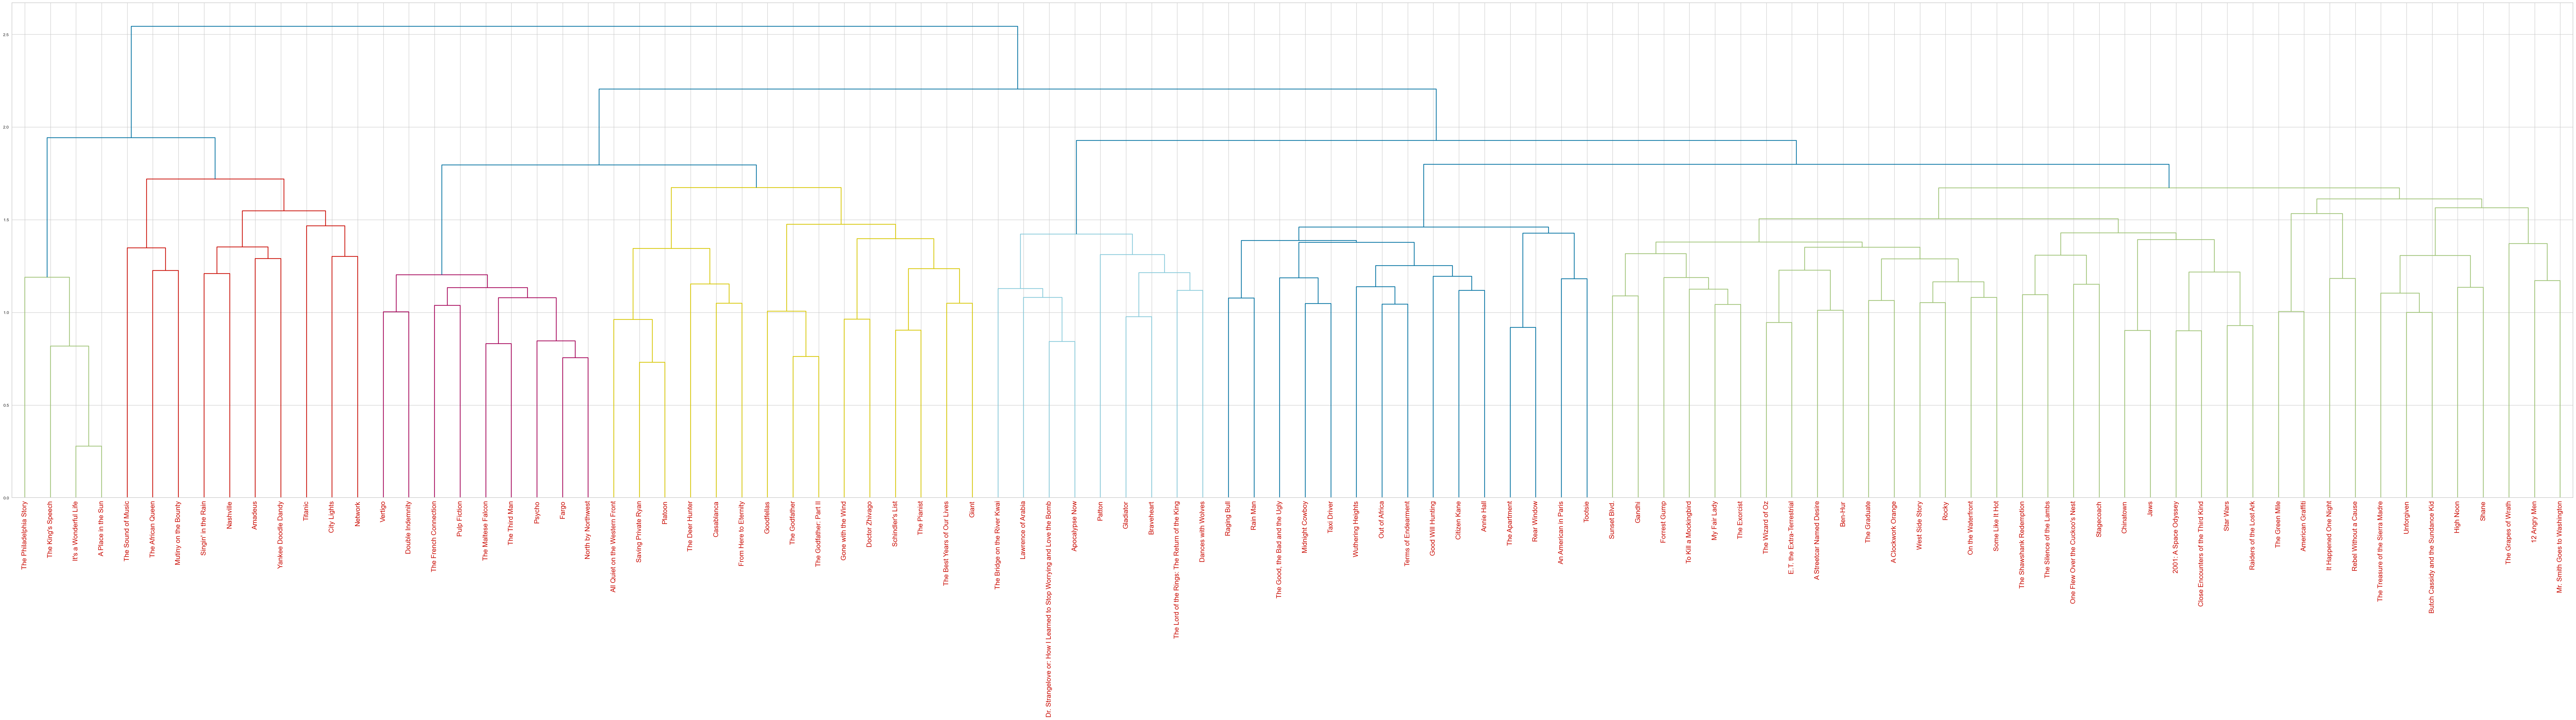

In [428]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()